In [62]:
# some code from DeepSDF https://github.com/facebookresearch/DeepSDF/tree/main

from torchvision import datasets, transforms
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import math

from torchinfo import summary
from easydict import EasyDict as ed
import time
import random

from model import SDFNet, Decoder
import workspace as ws
import os

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

In [141]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)) #0.1307(0.3081,)
        ])

dataset2 = datasets.MNIST('./data', train=False,
                    transform=transform)

class CustomSDFDataset(Dataset):
	def __init__(self, dataset):
		self.indices = range(len(dataset))
		self.sdf = dataset
		self.sampling_percent = 1
		self.sdf_dim = 28
		self.xy = self._init_xy()

	def _init_xy(self):
		x = np.linspace(0,1,self.sdf_dim)
		y = x
		xy = np.meshgrid(x, y)
		xy = np.stack(xy).reshape(2,-1).T
		return torch.tensor(xy, dtype=torch.float)
	
	def __len__(self):
		return len(self.sdf)

	def __getitem__(self, idx):
		pos_data, pos_idx = self._get_pos_data()
		sdf, label = self.sdf[idx]
		sdf_data = self._get_s_data(sdf, pos_idx)[:, None]
		# print(pos_data.shape)
		# print(sdf_data.shape)
		X = torch.cat([pos_data, sdf_data], dim=-1)
		return X, idx, label
	
	def _get_pos_data(self):
		sample_size = math.ceil(self.sampling_percent * (self.sdf_dim**2))
		# get indices to index a position index.
		pos_idx = random.sample(range(self.sdf_dim**2), sample_size)
		xy = self.xy[pos_idx]
		return self.xy[pos_idx], pos_idx
	
	def _get_s_data(self, sdf, pos_idx):
		return -sdf.flatten()[pos_idx]
	
	def get_pos_from_idx(self, idx_x, idx_y):
		return self.xy[idx_y*self.sdf_dim + idx_x]

train_kwargs = {'batch_size': 64, 'shuffle':True}

train_dataset = CustomSDFDataset(dataset2)
sdf_loader = torch.utils.data.DataLoader(train_dataset,**train_kwargs)

## Set training arguments and helper functions

In [66]:
### Helper functions ###
class LearningRateSchedule:
    def get_learning_rate(self, epoch):
        pass


class ConstantLearningRateSchedule(LearningRateSchedule):
    def __init__(self, value):
        self.value = value

    def get_learning_rate(self, epoch):
        return self.value


class StepLearningRateSchedule(LearningRateSchedule):
    def __init__(self, initial, interval, factor):
        self.initial = initial
        self.interval = interval
        self.factor = factor

    def get_learning_rate(self, epoch):

        return self.initial * (self.factor ** (epoch // self.interval))


class WarmupLearningRateSchedule(LearningRateSchedule):
    def __init__(self, initial, warmed_up, length):
        self.initial = initial
        self.warmed_up = warmed_up
        self.length = length

    def get_learning_rate(self, epoch):
        if epoch > self.length:
            return self.warmed_up
        return self.initial + (self.warmed_up - self.initial) * epoch / self.length

def get_learning_rate_schedules(specs):

    schedule_specs = specs["LearningRateSchedule"]

    schedules = []

    for schedule_specs in schedule_specs:

        if schedule_specs["Type"] == "Step":
            schedules.append(
                StepLearningRateSchedule(
                    schedule_specs["Initial"],
                    schedule_specs["Interval"],
                    schedule_specs["Factor"],
                )
            )
        elif schedule_specs["Type"] == "Warmup":
            schedules.append(
                WarmupLearningRateSchedule(
                    schedule_specs["Initial"],
                    schedule_specs["Final"],
                    schedule_specs["Length"],
                )
            )
        elif schedule_specs["Type"] == "Constant":
            schedules.append(ConstantLearningRateSchedule(schedule_specs["Value"]))

        else:
            raise Exception(
                'no known learning rate schedule of type "{}"'.format(
                    schedule_specs["Type"]
                )
            )
    return schedules

def save_model(experiment_directory, filename, decoder, epoch):

    model_params_dir = ws.get_model_params_dir(experiment_directory, True)

    torch.save(
        {"epoch": epoch, "model_state_dict": decoder.state_dict()},
        os.path.join(model_params_dir, filename),
    )


def save_optimizer(experiment_directory, filename, optimizer, epoch):

    optimizer_params_dir = ws.get_optimizer_params_dir(experiment_directory, True)

    torch.save(
        {"epoch": epoch, "optimizer_state_dict": optimizer.state_dict()},
        os.path.join(optimizer_params_dir, filename),
    )


def load_optimizer(experiment_directory, filename, optimizer):

    full_filename = os.path.join(
        ws.get_optimizer_params_dir(experiment_directory), filename
    )

    if not os.path.isfile(full_filename):
        raise Exception(
            'optimizer state dict "{}" does not exist'.format(full_filename)
        )

    data = torch.load(full_filename)

    optimizer.load_state_dict(data["optimizer_state_dict"])

    return data["epoch"]


def save_latent_vectors(experiment_directory, filename, latent_vec, epoch):

    latent_codes_dir = ws.get_latent_codes_dir(experiment_directory, True)

    all_latents = latent_vec.state_dict()

    torch.save(
        {"epoch": epoch, "latent_codes": all_latents},
        os.path.join(latent_codes_dir, filename),
    )

def save_logs(
    experiment_directory,
    loss_log,
    lr_log,
    timing_log,
    lat_mag_log,
    param_mag_log,
    epoch,
):

    torch.save(
        {
            "epoch": epoch,
            "loss": loss_log,
            "learning_rate": lr_log,
            "timing": timing_log,
            "latent_magnitude": lat_mag_log,
            "param_magnitude": param_mag_log,
        },
        os.path.join(experiment_directory, ws.logs_filename),
    )
    
def get_mean_latent_vector_magnitude(latent_vectors):
    return torch.mean(torch.norm(latent_vectors.weight.data.detach(), dim=1))

def append_parameter_magnitudes(param_mag_log, model):
    for name, param in model.named_parameters():
        if len(name) > 7 and name[:7] == "module.":
            name = name[7:]
        if name not in param_mag_log.keys():
            param_mag_log[name] = []
        param_mag_log[name].append(param.data.norm().item())

In [ ]:
### Training arguments ###
lrschedule = [
    { # Lr schedule for decoder
        "Type": "Step",
        "Initial":1e-4,
        "Interval":300, #Step at every nth epoch
        "Factor":0.5
    },
    { # lr schedule for embeddings
        "Type": "Step",
        "Initial":3e-4,
        "Interval":300,
        "Factor":0.5,
    }
]

config = {
    'latent_size': 3,
    'code_bound': 1,
    'code_regularization': True, #False, #True,
    "CodeRegularizationLambda": 1e-4,
    'CodeInitStdDev': 1.0,
    'LearningRateSchedule': lrschedule,
	'grad_clip': None, #2.0, # None, # 1.0, # None, # for decoder
	"SnapshotFrequency": 30, # checkpoints
    "NumEpochs": 2000,
    "LogFrequency": 5,
    "ClampingDistance": 0.3,
    "NetworkSpecs" : { # Not used (this is original DeepSDF specs)
		"dims" : [ 512, 512, 512, 512, 512, 512, 512, 512 ],
		"dropout" : [0, 1, 2, 3, 4, 5, 6, 7],
		"dropout_prob" : 0.2,
		"norm_layers" : [0, 1, 2, 3, 4, 5, 6, 7],
		"latent_in" : [4],
		"xyz_in_all" : False,
		"use_tanh" : False,
		"latent_dropout" : False,
		"weight_norm" : True
		},
}

config = ed(config)
experiment_directory = os.path.join('./experiment')

checkpoints = list(
	range(
		config["SnapshotFrequency"],
		config["NumEpochs"] + 1,
		config["SnapshotFrequency"],
	)
)

## Initialize Model + Embedding and Train

In [ ]:
# create embedding and initialize with random codes with normal distribution
num_scenes = len(train_dataset)
latent_size = config.latent_size
code_bound = config.code_bound
do_code_regularization = config.code_regularization
code_reg_lambda = config.CodeRegularizationLambda

lat_vecs = torch.nn.Embedding(num_scenes, latent_size, max_norm=code_bound)
torch.nn.init.normal_(
    lat_vecs.weight.data,
    0.0,
    config["CodeInitStdDev"] / math.sqrt(latent_size),
)

# initialize model
decoder = SDFNet(latent_size)

num_epochs = config.NumEpochs 
enforce_minmax = False #True
clamp_dist = config.ClampingDistance
minT = -clamp_dist
maxT = clamp_dist
num_samp_per_scene = math.ceil(train_dataset.sampling_percent * (train_dataset.sdf_dim**2))
batch_split = 1 #train_kwargs.batch_size * num_samp_per_scene

log_frequency = config.LogFrequency
loss_log = []
loss_batch_log = []
lr_log = []
lat_mag_log = []
timing_log = []
param_mag_log = {}

def save_checkpoints(epoch):
	save_model(experiment_directory, str(epoch) + ".pth", decoder, epoch)
	save_optimizer(experiment_directory, str(epoch) + ".pth", optimizer_all, epoch)
	save_latent_vectors(experiment_directory, str(epoch) + ".pth", lat_vecs, epoch)

def save_latest(epoch):
	save_model(experiment_directory, "latest.pth", decoder, epoch)
	save_optimizer(experiment_directory, "latest.pth", optimizer_all, epoch)
	save_latent_vectors(experiment_directory, "latest.pth", lat_vecs, epoch)

# Loss function
loss_l1 = torch.nn.L1Loss(reduction="sum")

# Learning rate scheduler and optimizer
lr_schedules = get_learning_rate_schedules(config)
optimizer_all = torch.optim.AdamW(
    [
        {
            "params": decoder.parameters(),
            "lr": lr_schedules[0].get_learning_rate(0),
        },
        {
            "params": lat_vecs.parameters(),
            "lr": lr_schedules[1].get_learning_rate(0),
        },
    ]
)

In [264]:
# Training loop
start_epoch = 0

for epoch in range(start_epoch, num_epochs + 1):
	start = time.time()
	decoder.train()
	batch = 0
	epoch_loss = 0.0
	for sdf_data, indices, labels in sdf_loader:
		batch += 1
		# Process the input data
		sdf_data = sdf_data.reshape(-1, 3)

		num_sdf_samples = sdf_data.shape[0]

		sdf_data.requires_grad = False

		xy = sdf_data[:, 0:2]
		sdf_gt = sdf_data[:, 2].unsqueeze(1)

		if enforce_minmax:
			sdf_gt = torch.clamp(sdf_gt, minT, maxT)
			
		indices = indices.unsqueeze(-1).repeat(1, num_samp_per_scene).view(-1)

		optimizer_all.zero_grad()

		batch_vecs = lat_vecs(indices)

		input = torch.cat([batch_vecs, xy], dim=1)

		# NN optimization
		pred_sdf = decoder(input)

		if enforce_minmax:
			pred_sdf = torch.clamp(pred_sdf, minT, maxT)

		chunk_loss = loss_l1(pred_sdf, sdf_gt) / num_sdf_samples

		if do_code_regularization:
			l2_size_loss = torch.sum(torch.norm(batch_vecs, dim=1))
			reg_loss = (
				code_reg_lambda * min(1, epoch / 100) * l2_size_loss
			) / num_sdf_samples

			chunk_loss = chunk_loss + reg_loss 

		chunk_loss.backward()

		epoch_loss += chunk_loss.item()

		loss_log.append(chunk_loss.item())

		if config.grad_clip is not None:
			torch.nn.utils.clip_grad_norm_(decoder.parameters(), config.grad_clip)

		optimizer_all.step()

		if batch % 43 == 0:
			batch_avg = np.mean(loss_log[-43:])
			loss_batch_log += batch_avg
			print(f'avg batch loss {batch_avg}')
	
	print(f'epoch {epoch}: {epoch_loss}')

	end = time.time()

	seconds_elapsed = end - start
	timing_log.append(seconds_elapsed)

	lr_log.append([schedule.get_learning_rate(epoch) for schedule in lr_schedules])

	lat_mag_log.append(get_mean_latent_vector_magnitude(lat_vecs))

	append_parameter_magnitudes(param_mag_log, decoder)

	if epoch in checkpoints:
		save_checkpoints(epoch)

	if epoch % log_frequency == 0:
		
		save_latest(epoch)
		save_logs(
			experiment_directory,
			loss_log,
			lr_log,
			timing_log,
			lat_mag_log,
			param_mag_log,
			epoch,
		)

avg batch loss 0.18457430497158406
avg batch loss 0.18267523930516355
avg batch loss 0.1819401442311531
epoch 1287: 28.765074148774147
avg batch loss 0.1833531416432802
avg batch loss 0.1821035233347915
avg batch loss 0.1834241671617641
epoch 1288: 28.76062075793743
avg batch loss 0.1838328904190729
avg batch loss 0.18265776370846948
avg batch loss 0.18454340169596117
epoch 1289: 28.780938655138016
avg batch loss 0.1818581781415052
avg batch loss 0.18434121407741724
avg batch loss 0.18366932279841844
epoch 1290: 28.77286970615387
avg batch loss 0.18332383695036866
avg batch loss 0.1832509345786516
avg batch loss 0.1819056435379871
epoch 1291: 28.767743811011314
avg batch loss 0.18368122501428738
avg batch loss 0.18433266670204873
avg batch loss 0.18033270087353018
epoch 1292: 28.74199779331684
avg batch loss 0.18125583196795264
avg batch loss 0.18481380336506423
avg batch loss 0.182878666145857
epoch 1293: 28.774041771888733
avg batch loss 0.18255380142566768
avg batch loss 0.183817010

#### Plot train data

tensor([0.1408, 0.1673, 0.1125, 0.0000, 0.0000], grad_fn=<SelectBackward0>)
torch.Size([1000, 1000])
-0.9234454
0.9999884


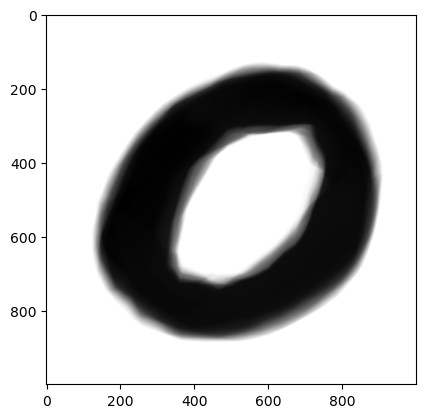

In [262]:
decoder.eval()

i = 25

wh = 1000
lat_vec = lat_vecs(torch.tensor(i))
x = y = np.linspace(0,1.0,wh)
xy = np.meshgrid(x, y)
xy = torch.tensor(np.stack(xy).reshape(2,-1).T, dtype=torch.float)

input = torch.cat([lat_vec.repeat(len(xy), 1), xy],-1)
print(input[0])
S = decoder(input)
S = S.view(wh,-1)
print(S.shape)
print(S.detach().numpy().min())
print(S.detach().numpy().max())
plt.imshow(S.detach().numpy(), cmap='gray')

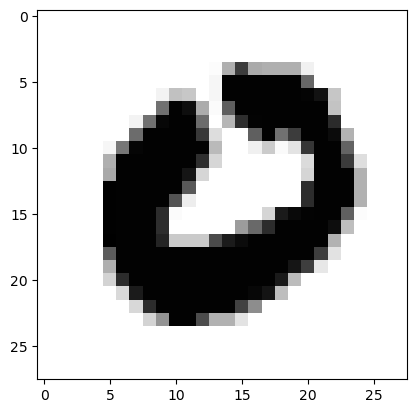

In [263]:
sdf_gt = -train_dataset.sdf[i][0]
plt.imshow(sdf_gt.squeeze().detach().numpy(), cmap='gray')